In [1]:
import pandas as pd
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import seaborn as sns                                  # Make the plots nicer to look at
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import matplotlib.ticker as tck
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
from scipy.signal import find_peaks,  peak_widths
from scipy import stats
import glob
import os

In [2]:
sys.path.append('External_Functions')
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

# In case you want to load function from a jupyter notebook from the current working directory, you can use the function below:
#   from ipynb.fs.full.ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

In [3]:
def line(x,a,b):
    """Just a line"""
    return a*x+b

def gauss_pdf(x, mu, sigma) :
    """Gaussian"""
    return 1.0 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2)

def exp_pdf(x, a, V0, s0):
    """Exponential"""
    return 0.5 * a * x**2 + V0 * x + s0

#def exp_inv(y, a, V0, s0):
#    return (-V0 + np.sqrt(V0**2 - 2 * a * s0 + 2 * a * y))/a

In [4]:
def weighted_average(distribution, weights):
    return round(sum([distribution[i]*weights[i] for i in range(len(distribution))])/sum(weights),2)

In [5]:
# Weighted Error and Average
def cal_avg_error(df):
    df = df.append(pd.Series(1, index=df.columns), ignore_index=True) #adds row
    Chi2, Chi2_prob, column_names = [], [], []
    for i in range(int(len(df.T)/2)):
        # Weighted Error and Average
        df.iloc[-1, i*2], df.iloc[-1, i*2+1], chi2, chi2_prob = w_mean(df.iloc[:-1, i*2], df.iloc[:-1, i*2+1])
        Chi2.append(chi2), Chi2_prob.append(chi2_prob), column_names.append(df.columns[i*2])
        
    return df, Chi2, Chi2_prob, column_names

def w_mean(dat,err):
    weight = 0
    for i in err:
        if i == 0:
            weight = 1
        else:
            weight += (1/i)**2

    mean_weighted = 0
    for i in range(len(dat)):
        mean_weighted += (float(dat[i])*(1/float(err[i]))**2)/weight

    err_weighted = np.sqrt(1/weight)
    
    Chi2 = np.sum(((np.array(dat)-mean_weighted)/np.array(err))**2)
    Chi2_prob = stats.chi2.sf(Chi2, len(dat)-1)
        
    return mean_weighted, err_weighted, Chi2, Chi2_prob

In [6]:
def peak_finder(df, offset=0, line=1, peakN=0, plot=True, zoom=False):
    
    peaks, _ = find_peaks(df.iloc[:,1], height=line)
    widths = peak_widths(df.iloc[:,1], peaks, rel_height=0.5)
    
    #FROM FLOAT TO INT
    for i in range(len(widths[2:])):
        for j in range(len(widths[2:][i])):
            widths[2:][i][j] = int(round(widths[2:][i][j]))
    
    df.iloc[:,0] -= df.iloc[:,0][peaks[0]] - offset
    
    #APPEND TO widths_list
    widths_list = []
    
    for i in range(len(df.iloc[:,0][widths[2]])):
         widths_list.append((df.iloc[:,0][widths[3][i]]-df.iloc[:,0][widths[2][i]])/2)
    
    
    if plot == True:
        plt.plot(df.iloc[:,0], df.iloc[:,1])
        plt.plot(df.iloc[:,0][peaks], df.iloc[:,1][peaks], "x")
        plt.plot(df.iloc[:,0], np.ones_like(df.iloc[:,1])*line, "--", color="gray")
        plt.hlines(widths[1],df.iloc[:,0][widths[2]], df.iloc[:,0][widths[3]] , color="red")
 
        plt.xlim([-0.10, df.iloc[:,0][peaks[-1]] + 0.10])
    
    if zoom == True:
        plt.xlim([df.iloc[:,0][peaks[peakN]]-0.02, df.iloc[:,0][peaks[peakN]] + 0.02])
        plt.ylim([df.iloc[:,1][peaks[peakN]]-0.001, df.iloc[:,1][peaks[peakN]] + 0.001])
    
    if plot == True:
        plt.show()
        
    return df.iloc[:,0][peaks], widths_list

In [7]:
Rol_main = pd.read_csv (r'CSV/Rolling_ball_main.csv', sep=";")
Rol_left = pd.read_csv (r'CSV/Rolling_ball_left.csv', sep=";")
Rol_right = pd.read_csv (r'CSV/Rolling_ball_right.csv', sep=";")

In [8]:
Rol_main

,Slit_size_mm,Slit_size_mm_error,Stor_kulge_mm,Stor_kulge_mm_error,Lille_kulge_mm,Lille_kulge_mm_error,Sensor1_mm,Sensor1_mm_error,Sensor2_mm,Sensor2_mm_error,...,Sensor4_mm,Sensor4_mm_error,Sensor5_mm,Sensor5_mm_error,Længde_mm,Længde_mm_error,Højde_mm,Højde_mm_error,Lille_højde_mm,Lille_højde_mm_error
0,5.8,0.04,12.81,0.05,11.10,0.05,797.0,0.7,631.5,0.7,...,290.5,0.7,113.0,0.7,888.88,0.2,241.2,0.2,26.40,0.03
1,6.0,0.02,12.76,0.04,11.02,0.04,797.0,0.5,632.0,0.5,...,291.5,0.5,113.0,0.5,889.00,0.3,241.1,0.3,26.68,0.02
2,5.8,0.02,12.71,0.02,11.01,0.02,797.2,0.3,631.8,0.3,...,290.4,0.3,113.8,0.3,888.90,0.2,241.1,0.2,26.52,0.02
3,6.0,0.05,12.79,0.05,11.03,0.05,797.2,0.4,631.8,0.4,...,290.5,0.4,113.0,0.4,889.10,0.3,240.5,0.4,26.48,0.05


In [9]:
path = r'Data/Rolling_ball/csv/' # use your path
names_list = np.sort(os.listdir(path))

for i in range(len(names_list)):
    names_list[i] = names_list[i].replace('.csv', '')

for i in names_list: 
    locals()[i] = pd.read_csv((path + i + '.csv'), index_col=None, sep=',', skiprows=14)

print(names_list)

['Slope_1_1_stor_venstre' 'Slope_1_2_stor_venstre'
 'Slope_1_3_stor_venstre' 'Slope_1_4_stor_venstre'
 'Slope_2_1_lille_venstre' 'Slope_2_2_lille_venstre'
 'Slope_2_3_lille_venstre' 'Slope_2_4_lille_venstre'
 'Slope_3_1_stor_højdre' 'Slope_3_2_stor_højdre' 'Slope_3_3_stor_højdre'
 'Slope_3_4_stor_højdre' 'Slope_4_1_lille_højdre' 'Slope_4_2_lille_højdre'
 'Slope_4_3_lille_højdre' 'Slope_4_4_lille_højdre'
 'Slope_5_1_lille_freefall' 'Slope_5_2_lille_freefall']


In [10]:
peak_time_list, peak_FWHM_list = [], []

for i in names_list:
    locals()[i+'_peak_time'], locals()[i+'_peak_FWHM']  = peak_finder(locals()[i], offset = 0, plot=False)
    #print([i+'_peak_FWHM'])
    peak_time_list.append([i+'_peak_time'][0])
    peak_FWHM_list.append([i+'_peak_FWHM'][0])

In [11]:
Slope_1_1_stor_venstre_peak_FWHM

[0.010069999999999966,
 0.006379999999999997,
 0.005020000000000052,
 0.004489999999999994,
 0.003960000000000075]

In [12]:
locals()[peak_time_list[0]].values

array([0.     , 0.23348, 0.40982, 0.5443 , 0.67006])

In [13]:
df_left = cal_avg_error(Rol_left)[0][-1:]

vinkel_v, vinkel_v_err, *ignore = w_mean([df_left["Vinkel_left_front_grader"].values[0],df_left["Vinkel_left_bagside_grader"].values[0]],[df_left["Vinkel_left_front_grader_error"].values[0],df_left["Vinkel_left_bagside_grader_error"].values[0]])

In [14]:
df_right = cal_avg_error(Rol_right)[0][-1:]
vinkel_h, vinkel_h_err, *ignore = w_mean([df_right["Vinkel_right_front_grader"].values[0],df_right["Vinkel_right_bagside_grader"].values[0]],[df_right["Vinkel_right_front_grader_error"].values[0],df_right["Vinkel_right_bagside_grader_error"].values[0]])

In [15]:
D_vinkel = abs(vinkel_v-vinkel_h)/2
D_vinkel_err = np.sqrt((vinkel_h_err**2)/4 + (vinkel_v_err**2)/4)
print(D_vinkel,u"\u00B1",D_vinkel_err,"degrees")

print(90-vinkel_v,u"\u00B1",vinkel_v_err,"degrees")
print(90-vinkel_h,u"\u00B1",vinkel_h_err,"degrees")

"""
print(90-vinkel_v+D_vinkel)
vinkel = 90-(vinkel_v + vinkel_h)/2
vinkel_err = np.sqrt((vinkel_h_err**2)/4 + (vinkel_v_err**2)/4)
print(vinkel,u"\u00B1",vinkel_err,"degrees")
"""

0.35645730058942604 ± 0.054028074895080574 degrees
13.446544858280618 ± 0.09183075881332191 degrees
14.15945945945947 ± 0.05694947974514993 degrees


'\nprint(90-vinkel_v+D_vinkel)\nvinkel = 90-(vinkel_v + vinkel_h)/2\nvinkel_err = np.sqrt((vinkel_h_err**2)/4 + (vinkel_v_err**2)/4)\nprint(vinkel,u"±",vinkel_err,"degrees")\n'

In [16]:
df_main = cal_avg_error(Rol_main)[0][-1:]

Slit = df_main.values[0][0]
Slit_err  =df_main.values[0][1]
Stor_kugle = df_main.values[0][2]
Stor_kugle_err = df_main.values[0][3]
Lille_kugle = df_main.values[0][4]
Lille_kugle_err = df_main.values[0][5]
L = df_main.values[0][16]
L_err = df_main.values[0][17]
H = df_main.values[0][18]
H_err = df_main.values[0][19]
h = df_main.values[0][20]
h_err = df_main.values[0][21]

In [17]:
#Trig
vinkel_trig = np.arctan((H-h)/L)* 180/np.pi
vinkel_trig_err = np.sqrt(((H-h)**2 / (H**2 - 2*H*h + L**2 + h**2)**2)*L_err**2 + (L**2 / (H**2 - 2*H*h + L**2 + h**2)**2)*H_err**2 + (L**2 / (H**2 - 2*H*h + L**2 + h**2)**2)*h_err**2) * 180/np.pi

print(vinkel_trig,u"\u00B1",vinkel_trig_err,"degrees")

vinkel_trig_medD = vinkel_trig+D_vinkel
vinkel_trig_medD_err = np.sqrt(vinkel_trig_err**2 + D_vinkel_err**2)
print(vinkel_trig_medD,u"\u00B1",vinkel_trig_medD_err,"degrees")

vinkel_trig_minusD = vinkel_trig-D_vinkel
vinkel_trig_minusD_err = np.sqrt(vinkel_trig_err**2 + D_vinkel_err**2)
print(vinkel_trig_minusD,u"\u00B1",vinkel_trig_minusD_err,"degrees")

13.567474739278817 ± 0.007657180776516778 degrees
13.923932039868243 ± 0.054567987816234294 degrees
13.21101743868939 ± 0.054567987816234294 degrees


In [18]:
#vægtet gennemsnit af vinkel fra clinometer med rampe mod højre og trigonometri vinkel + Delta
theta_h, theta_h_err, theta_h_chi2, theta_h_p = w_mean([90-vinkel_h,vinkel_trig_medD],[vinkel_h_err,vinkel_trig_medD_err])
print(theta_h, theta_h_err, theta_h_chi2, theta_h_p)

14.036668277500077 0.03940041465695879 8.91721282259779 0.002824953117881827


In [19]:
#vægtet gennemsnit af vinkel fra clinometer med rampe mod venstre og trigonometri vinkel + Delta
theta_v, theta_v_err, theta_v_chi2, theta_v_p = w_mean([90-vinkel_v,vinkel_trig_minusD],[vinkel_v_err,vinkel_trig_minusD_err])
print(theta_v, theta_v_err, theta_v_chi2, theta_v_p)

13.272479997852503 0.046910790961899686 4.861566539667881 0.027461390584995676


In [20]:
#Chi2 og p-values af weighted means
Chisquare = cal_avg_error(Rol_main)[1]
p_value = cal_avg_error(Rol_main)[2]
mes = cal_avg_error(Rol_main)[3]
for i in range(len(mes)):
    print(mes[i],Chisquare[i],p_value[i])

Chisquare = cal_avg_error(Rol_left)[1]
p_value = cal_avg_error(Rol_left)[2]
mes = cal_avg_error(Rol_left)[3]
for i in range(len(mes)):
    print(mes[i],Chisquare[i],p_value[i])

Chisquare = cal_avg_error(Rol_right)[1]
p_value = cal_avg_error(Rol_right)[2]
mes = cal_avg_error(Rol_right)[3]
for i in range(len(mes)):
    print(mes[i],Chisquare[i],p_value[i])

Slit_size_mm 60.165975103734546 5.417343967271507e-13
Stor_kulge_mm 5.406433121018983 0.14434329883752334
Lille_kulge_mm 2.8191719745222823 0.4203535854255297
Sensor1_mm 0.17925922337160838 0.980866006740654
Sensor2_mm 0.34216709866525824 0.9519123273345345
Sensor3_mm 0.6337782514957843 0.8886579197368536
Sensor4_mm 3.7544875366392447 0.28922456139802283
Sensor5_mm 3.734793246287612 0.29156241775683145
Længde_mm 0.45440170940184876 0.9287886728446813
Højde_mm 2.4768041237112652 0.4794976867424354
Lille_højde_mm 70.98976109215056 2.6199955404531276e-15
Vinkel_left_front_grader 0.0 1.0
Vinkel_left_bagside_grader 0.13311688311686798 0.987586591974639
Vinkel_right_front_grader 0.0 1.0
Vinkel_right_bagside_grader 0.27253668763099625 0.9651080295435146


In [21]:
offset = 0

Sensor_list = []
Rol_main_updated = cal_avg_error(Rol_main)[0]
copy = Rol_main_updated.iloc[-1:,6].copy()
for i in range(5):
    x = abs(Rol_main_updated.iloc[-1:,6+2*i]- copy)

    Rol_main_updated.iloc[-1:,6+2*i] = x + offset
    Sensor_list.append(float(x))
    
Rol_main_updated

,Slit_size_mm,Slit_size_mm_error,Stor_kulge_mm,Stor_kulge_mm_error,Lille_kulge_mm,Lille_kulge_mm_error,Sensor1_mm,Sensor1_mm_error,Sensor2_mm,Sensor2_mm_error,...,Sensor4_mm,Sensor4_mm_error,Sensor5_mm,Sensor5_mm_error,Længde_mm,Længde_mm_error,Højde_mm,Højde_mm_error,Lille_højde_mm,Lille_højde_mm_error
0,5.800000,0.040000,12.810000,0.050000,11.100000,0.050000,797.0,0.700000,631.50000,0.700000,...,290.500000,0.700000,113.000000,0.700000,888.880000,0.20000,241.200000,0.200000,26.400000,0.030000
1,6.000000,0.020000,12.760000,0.040000,11.020000,0.040000,797.0,0.500000,632.00000,0.500000,...,291.500000,0.500000,113.000000,0.500000,889.000000,0.30000,241.100000,0.300000,26.680000,0.020000
2,5.800000,0.020000,12.710000,0.020000,11.010000,0.020000,797.2,0.300000,631.80000,0.300000,...,290.400000,0.300000,113.800000,0.300000,888.900000,0.20000,241.100000,0.200000,26.520000,0.020000
3,6.000000,0.050000,12.790000,0.050000,11.030000,0.050000,797.2,0.400000,631.80000,0.400000,...,290.500000,0.400000,113.000000,0.400000,889.100000,0.30000,240.500000,0.400000,26.480000,0.050000
4,5.896266,0.012883,12.736306,0.015962,11.022803,0.015962,0.0,0.206716,165.34035,0.206716,...,506.524927,0.206716,683.768538,0.206716,888.939231,0.11767,241.081443,0.121842,26.558498,0.012393


In [22]:
def parabel(x,a,b,c):
    return 0.5*a*x**2 + b*x + c

def acc_calc(peak_times):
    dist = Sensor_list
    acc_list = []
    acc_err_list = []
    for peak_time in peak_times:
        t = globals()[peak_time].values

        chi2 = Chi2Regression(parabel, t, dist,1/50000)
        m = Minuit(chi2,a=0,b=0,c=0)
        m.errordef = 1.0
        m.migrad()
        a, b, c=m.values
        acc_list.append(a)
        acc_err_list.append(m.errors["a"])

    acc, acc_err, Chi2, Chi2_prob = w_mean(acc_list,acc_err_list)
    return acc, acc_err

In [23]:
acc_stor_v, acc_stor_v_err = acc_calc(peak_time_list[0:4])
acc_stor_h, acc_stor_h_err = acc_calc(peak_time_list[8:12])

acc_lille_v, acc_lille_v_err = acc_calc(peak_time_list[4:8])
acc_lille_h, acc_lille_h_err = acc_calc(peak_time_list[12:16])

acc_free, acc_free_err = acc_calc(peak_time_list[16:18])

print("acc stor venstre=",acc_stor_v,u"\u00B1",acc_stor_v_err,"mm/s")
print("acc stor højre=",acc_stor_h,u"\u00B1",acc_stor_h_err,"mm/s")
print("acc lille venstre=",acc_lille_v,u"\u00B1",acc_lille_v_err,"mm/s")
print("acc lille højre=",acc_lille_h,u"\u00B1",acc_lille_h_err,"mm/s")
print("acc free fall=",acc_free,u"\u00B1",acc_free_err,"mm/s")

acc stor venstre= 1428.409292858999 ± 0.00018974945294641387 mm/s
acc stor højre= 1508.8804308044546 ± 0.00019991798376951423 mm/s
acc lille venstre= 1374.0571620218666 ± 0.00018200725189670053 mm/s
acc lille højre= 1461.8095442221697 ± 0.0001933487997600879 mm/s
acc free fall= 9657.66598687784 ± 0.0015216455678378718 mm/s


In [24]:
def plot_res(data_x, data_y, data_y_err, res, minuit_fit, minuit_error, res_error,
             Chi2=None, Nbins=None, figsize=(8, 6), name=None):
    
    sigma = res_error
    sigma_sensor = Rol_main_updated.iloc[-1,7]
    x_axis = np.linspace(min(x), max(x), 1000)
    
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot()

    ax1.set_ylabel('Position (mm)')
    ax1.set_xlabel('Time (s)')

    
    #Adding exstra y-axis:
    ax2 = ax1.twinx()
    ax2.set_ylabel('Residuals (mm)')
    ax2.yaxis.set_minor_locator(tck.AutoMinorLocator(5))
    ax2.yaxis.set_major_locator(tck.MultipleLocator(0.5))
    
    #Plotting main data:
    ax1.plot(data_x, data_y, '.', color='black')
    ax1.errorbar(data_x, data_y, fmt='none', yerr=data_y_err, color='red')
    ax1.plot(x_axis, exp_pdf(x_axis, *minuit_fit))
    

    #Plotting residuals data:
    ax2.plot(data_x, res, '.', color='black')
    ax2.errorbar(data_x, res, fmt='none', yerr=sigma_sensor, color='red')
    ax2.axhline(res.mean(), color='grey', linestyle='-')

    ax2.axhline(res.mean() + sigma, color='grey', linestyle=':')
    ax2.axhline(res.mean() - sigma, color='grey', linestyle=':')

    #Adding legend (and cal of Chi2_prob)
    Chi2_prob = stats.chi2.sf(Chi2, len(data_x)-3)

   
    if "Stor" in name == True:
        size = 'Big'
    else:
        size = 'Small'
        
    
    if ("venstre" in name) == True:
        di = 'Left'
        
    if ("højdre" in name) == True:
        di = 'Right'
        
    if ("freefall" in name) == True:
        di = 'Freefall'
    
    Fitnumber = name.replace('_','.')[6:9]
    
    ax2.text(0, 2.9, 
             #text in plot: 
             (f"Fit number: {Fitnumber}\nBall size: {size} \nDirection: {di}") +
             (f'\n\nAcceleration = {minuit_fit[0]:.2f} +/- {minuit_error[0]:.2f} mm/s\u00b2 \n'
             f'Chi\u00b2 = {Chi2:.2f} \n'
             f'Chi\u00b2 probability = {Chi2_prob:.2f} \n\n'
            ))
    
    #Setting limits:
    ax1.set_ylim([min(data_y)-225, max(data_y)+75])
    ax2.set_ylim([-0.75, 5])

    return plt.show(), minuit_fit[0], minuit_error[0]

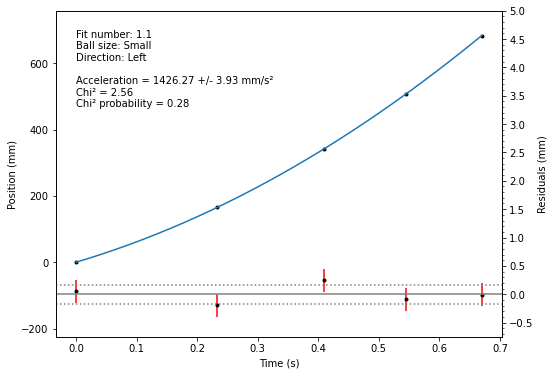

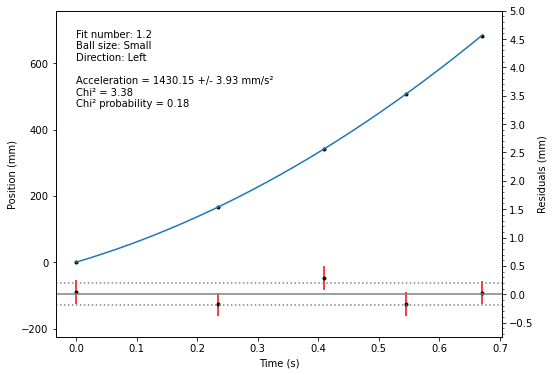

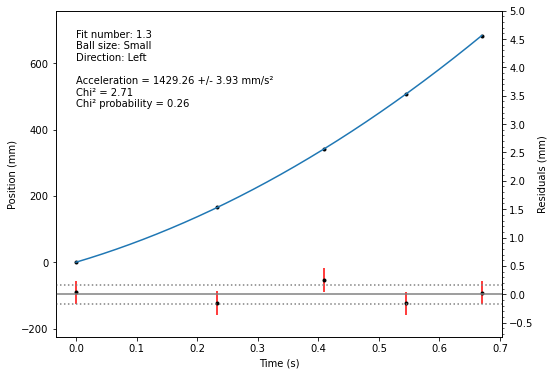

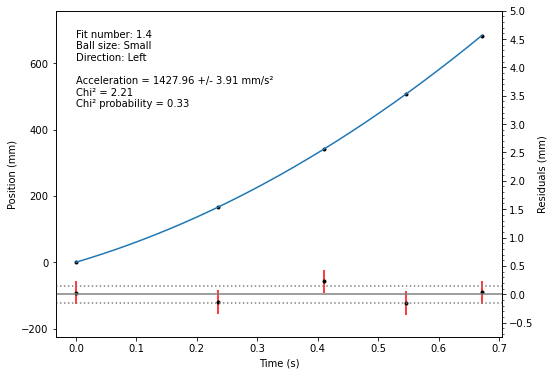

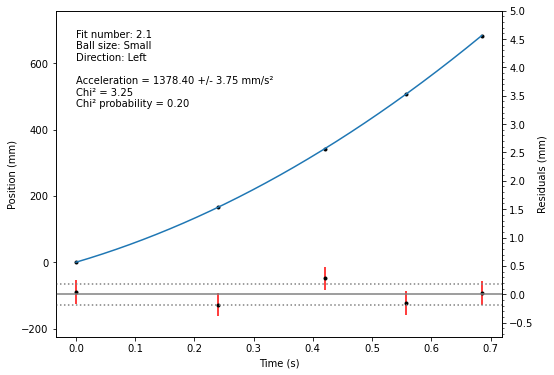

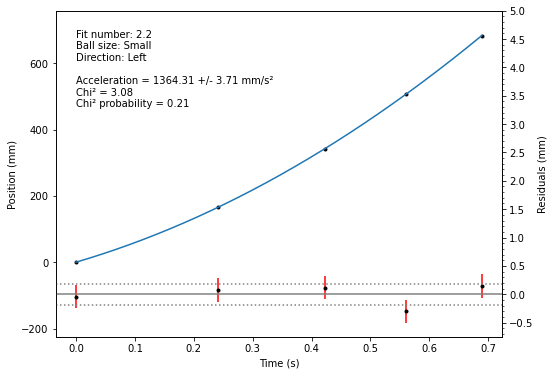

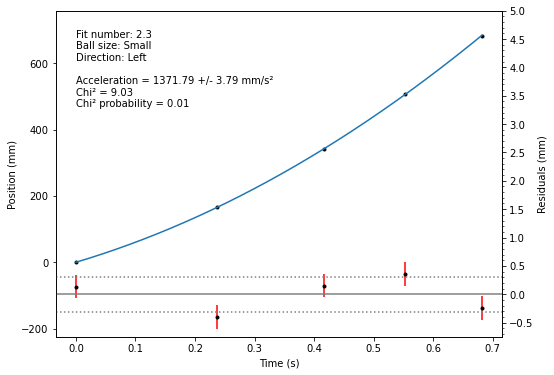

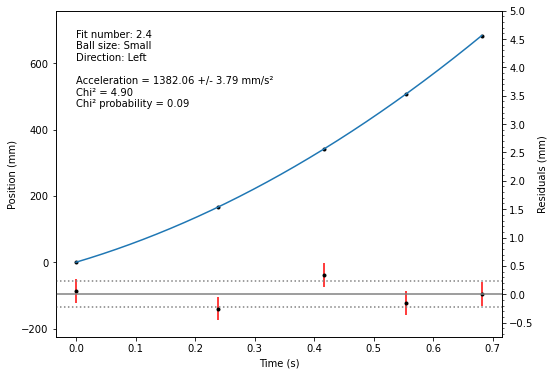

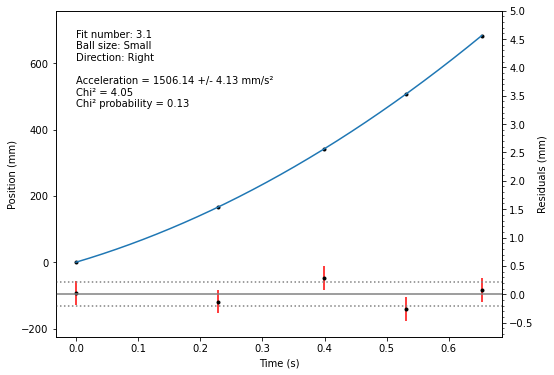

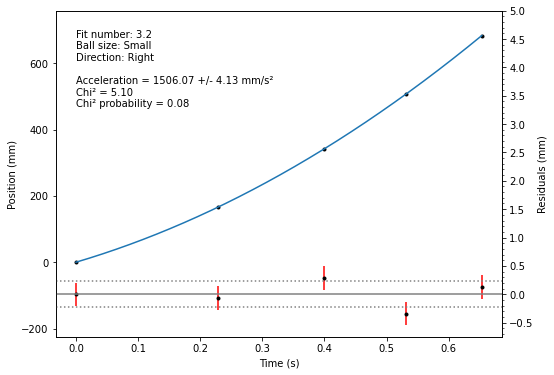

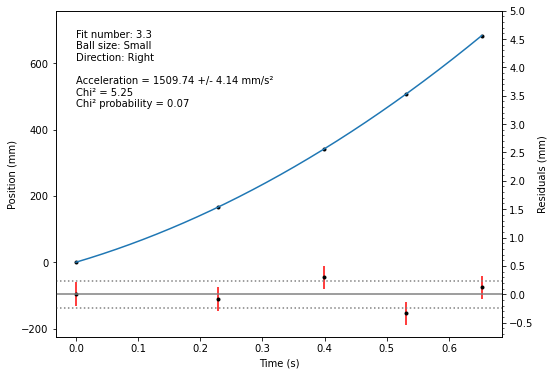

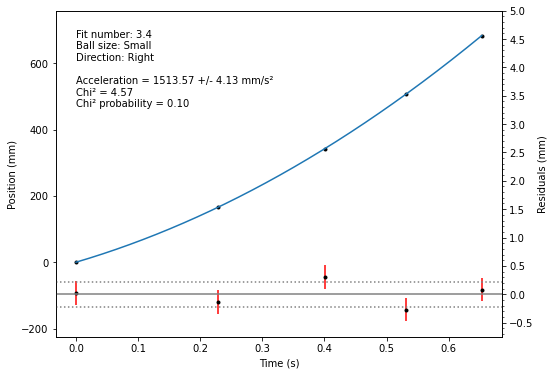

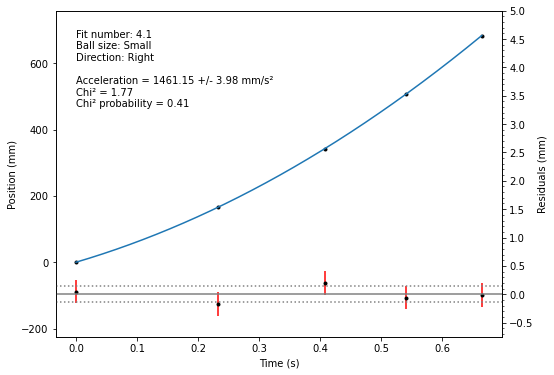

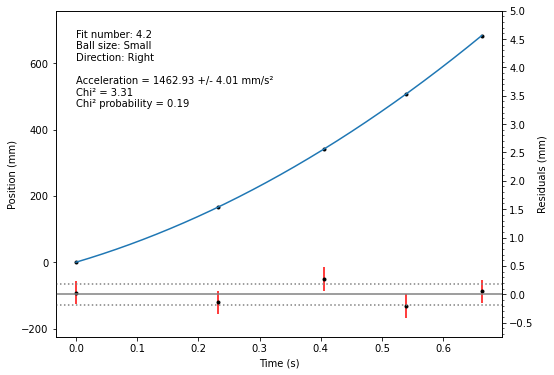

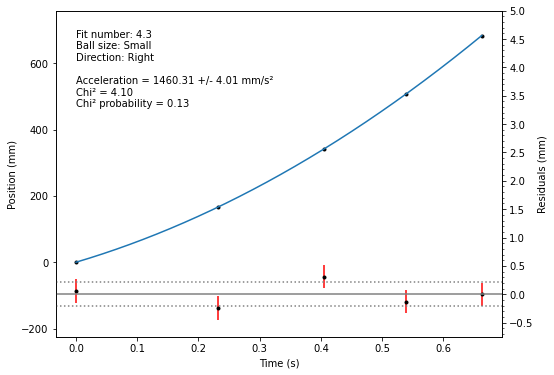

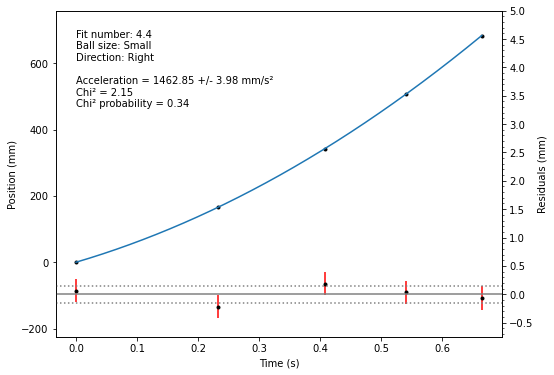

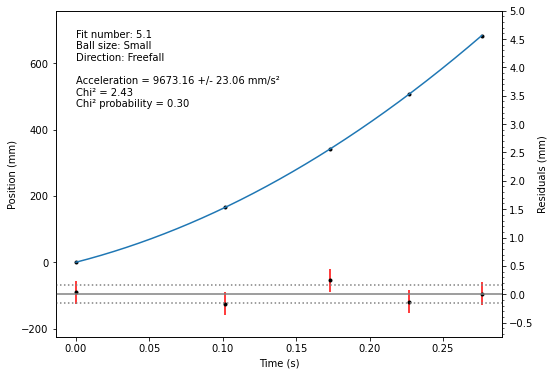

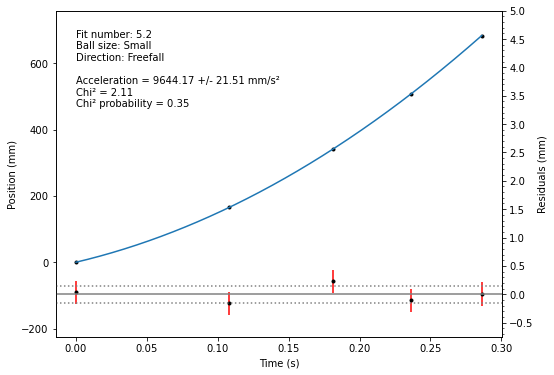

In [25]:
Minuit.print_level = 1
acc_list = []
acc_err_list = []
for i in names_list:
    Minuit.print_level += 1
    
    x, y = locals()[i+'_peak_time'], Sensor_list
    
    x_axis = np.linspace(min(x), max(x), 1000)
    y_err = np.ones(len(y))*Rol_main_updated.iloc[-1,7]
    
    chi2fit = Chi2Regression(exp_pdf, x, y, sy=y_err)

    
    minuit_chi2 = Minuit(chi2fit, a=5, V0=1, s0=0)
    minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
    minuit_chi2.migrad()
    
 
    res = y - exp_pdf(x, *minuit_chi2.values[:])
    
    plot, acc, acc_err = plot_res(x, y, y_err, res, minuit_chi2.values[:], minuit_chi2.errors[:], Chi2=minuit_chi2.fval, res_error=res.std(), figsize=(8, 6), name=i)
    acc_list.append(acc)
    acc_err_list.append(acc_err)

In [26]:
acc_stor_v, acc_stor_v_err, acc_stor_v_chi2,acc_stor_v_p  = w_mean(acc_list[0:4],acc_err_list[0:4])
acc_stor_h, acc_stor_h_err, acc_stor_h_chi2,acc_stor_h_p  = w_mean(acc_list[8:12],acc_err_list[8:12])

acc_lille_v, acc_lille_v_err, acc_lille_v_chi2,acc_lille_v_p  = w_mean(acc_list[4:8],acc_err_list[4:8])
acc_lille_h, acc_lille_h_err, acc_lille_h_chi2,acc_lille_h_p  = w_mean(acc_list[12:16],acc_err_list[12:16])

acc_free, acc_free_err, acc_free_chi2, acc_free_p = w_mean(acc_list[16:18],acc_err_list[16:18])

print("acc stor venstre=",acc_stor_v,u"\u00B1",acc_stor_v_err,"mm/s")
print("acc stor højre=",acc_stor_h,u"\u00B1",acc_stor_h_err,"mm/s")
print("acc lille venstre=",acc_lille_v,u"\u00B1",acc_lille_v_err,"mm/s")
print("acc lille højre=",acc_lille_h,u"\u00B1",acc_lille_h_err,"mm/s")
print("acc free fall=",acc_free,u"\u00B1",acc_free_err,"mm/s")

acc stor venstre= 1428.4092764271377 ± 1.9611783648633867 mm/s
acc stor højre= 1508.8803978135047 ± 2.0662444180655166 mm/s
acc lille venstre= 1374.056975949473 ± 1.881217628855155 mm/s
acc lille højre= 1461.8095423869129 ± 1.9984417720454117 mm/s
acc free fall= 9657.66461557306 ± 15.727584029273142 mm/s


In [27]:
g_stor_v = (acc_stor_v/np.sin((90-vinkel_v)*np.pi/180))*(1 + (2/5) * Stor_kugle**2/(Stor_kugle**2 - Slit**2))
print(g_stor_v)
g_stor_h = (acc_stor_h/np.sin((90-vinkel_h)*np.pi/180))*(1 + (2/5) * Stor_kugle**2/(Stor_kugle**2 - Slit**2))
print(g_stor_h)

g_lille_v = (acc_lille_v/np.sin((90-vinkel_v)*np.pi/180))*(1 + (2/5) * Lille_kugle**2/(Lille_kugle**2 - Slit**2))
print(g_lille_v)
g_lille_h = (acc_lille_h/np.sin((90-vinkel_h)*np.pi/180))*(1 + (2/5) * Lille_kugle**2/(Lille_kugle**2 - Slit**2))
print(g_lille_h)

9270.022690442283
9308.562328383547
9219.916808049684
9324.224314244742


In [28]:
#Trig
g_stor_v = (acc_stor_v/np.sin((vinkel_trig)*np.pi/180 - D_vinkel*np.pi/180))*(1 + (2/5) * Stor_kugle**2/(Stor_kugle**2 - Slit**2))
print(g_stor_v)
g_stor_h = (acc_stor_h/np.sin((vinkel_trig)*np.pi/180 + D_vinkel*np.pi/180))*(1 + (2/5) * Stor_kugle**2/(Stor_kugle**2 - Slit**2))
print(g_stor_h)

g_lille_v = (acc_lille_v/np.sin((vinkel_trig)*np.pi/180 - D_vinkel*np.pi/180))*(1 + (2/5) * Lille_kugle**2/(Lille_kugle**2 - Slit**2))
print(g_lille_v)
g_lille_h = (acc_lille_h/np.sin((vinkel_trig)*np.pi/180 + D_vinkel*np.pi/180))*(1 + (2/5) * Lille_kugle**2/(Lille_kugle**2 - Slit**2))
print(g_lille_h)

9432.27160881058
9462.828352465895
9381.288746339986
9478.749896377281


In [29]:
#clinometer og trig vinkel lagt sammen
g_stor_v = (acc_stor_v/np.sin(theta_v*np.pi/180))*(1 + (2/5) * Stor_kugle**2/(Stor_kugle**2 - Slit**2))
print(g_stor_v)
g_stor_h = (acc_stor_h/np.sin(theta_h*np.pi/180))*(1 + (2/5) * Stor_kugle**2/(Stor_kugle**2 - Slit**2))
print(g_stor_h)

g_lille_v = (acc_lille_v/np.sin(theta_v*np.pi/180))*(1 + (2/5) * Lille_kugle**2/(Lille_kugle**2 - Slit**2))
print(g_lille_v)
g_lille_h = (acc_lille_h/np.sin(theta_h*np.pi/180))*(1 + (2/5) * Lille_kugle**2/(Lille_kugle**2 - Slit**2))
print(g_lille_h)

9389.37107142942
9388.335483751182
9338.620092887524
9404.131690772145
